In [4]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

# Собственная реализация

In [ ]:
from IPython.display import Image
Image("/Users/d.merkushov/Desktop/conv.png")

In [6]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.6)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

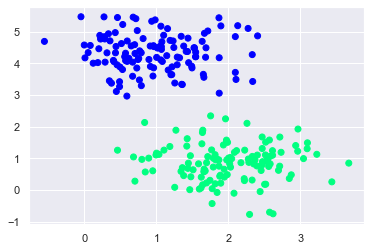

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [238]:
class LinearSVM():
    def __init__(self, C=1, gamma=1):
        self._C = C
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        mask = a > 0.001
        self.a = a[mask]
        self.sv = X[mask]
        self.sv_y = y[mask]
        self.w = np.sum(self.a[:,None] * self.sv * self.sv_y[:,None], axis=0)
        self.b = np.dot(self.w, self.sv[0]) - self.sv_y[0]
    
    def project(self, X):
        tmp = self.a[:,None] * self.sv_y[:,None] * self.sv
        return np.sum( tmp * X[:, np.newaxis, :], axis=(1, 2)) - self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        print(xy.shape)
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  1e-15  8e-15
 6: -4.0061e+00 -4.0104e+00  4e-03  2e-15  5e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  1e-15  5e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  6e-15
Optimal solution found.
(900, 2)


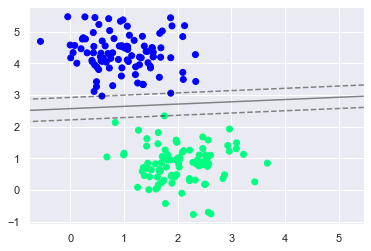

In [240]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

In [242]:
pred = svm.predict(X_test)
target = y_test

In [244]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print(classification_report(target, pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        34

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



# Нелинейный случай

In [245]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

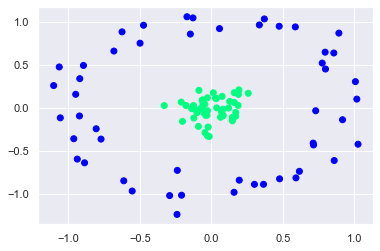

In [246]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [248]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -7.4180e+01 -1.6364e+02  9e+01  4e-16  2e+00
 1: -1.6721e+02 -1.7213e+02  5e+00  4e-15  1e+00
 2: -5.7967e+03 -5.8029e+03  6e+00  6e-13  1e+00
 3: -5.2930e+06 -5.2930e+06  6e+01  1e-10  1e+00
 4: -2.3657e+11 -2.3658e+11  1e+06  9e-06  1e+00
Terminated (singular KKT matrix).


(900, 2)


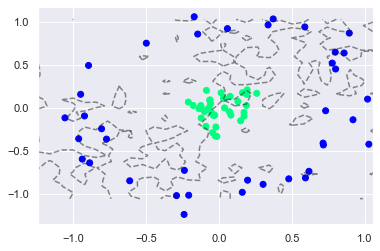

In [249]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

## Kernel SVM

In [279]:
class KernelSVM:
    def __init__(self, C=1, ker='rbf', gamma=1):
        self._C = C
        self._Ker = self.linear
        if ker=='rbf': self._Ker = self.rbf
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self._Ker(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        
        mask = np.abs(a) > 0.001
        self.a = a[mask]
        print(a)
        self.sv = X[mask]
        self.sv_y = y[mask]
        self.w = np.sum(self.a[:,None] * self.sv * self.sv_y[:,None], axis=0)
        self.b = np.dot(self.w, self.sv[0]) - self.sv_y[0]
    
    def rbf(self, x, y):
        if len(x.shape) > 1:
            return np.exp(-np.diagonal(np.dot(x-y, (x-y).T)) * self._gamma)
        else: 
            return np.exp(-(np.dot(x-y, (x-y).T)))
        
    def linear(self, x, y):
        return np.dot(x, y.T)
    
    def project(self, X):
        sum = 0
        for n in range(len(self.a)):
            sum += self.a[n] * self.sv_y[n] * self._Ker(X, self.sv[n])
        return sum + self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--']);

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [283]:
svm = KernelSVM(C=0.000001, ker='rbf',gamma=5)
svm.fit(X_train, y_train)

svm.plot(X)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')

     pcost       dcost       gap    pres   dres
 0: -6.1370e-12 -9.3859e-06  8e+01  9e+00  9e+00
 1:  2.8232e+00 -2.8232e+00  6e+00  2e-15  3e-15
 2:  4.1373e-01 -4.1373e-01  8e-01  3e-16  3e-15
 3:  6.0631e-02 -6.0632e-02  1e-01  3e-16  1e-15
 4:  8.8851e-03 -8.8855e-03  2e-02  1e-16  4e-16
 5:  1.3020e-03 -1.3022e-03  3e-03  2e-17  1e-16
 6:  1.9079e-04 -1.9085e-04  4e-04  3e-18  6e-17
 7:  2.7952e-05 -2.7976e-05  6e-05  1e-18  2e-17
 8:  4.0935e-06 -4.1025e-06  8e-06  9e-19  8e-18
 9:  5.9883e-07 -6.0227e-07  1e-06  2e-19  3e-18
10:  8.7348e-08 -8.8669e-08  2e-07  3e-19  1e-18
11:  1.2643e-08 -1.3151e-08  3e-08  3e-20  5e-19
Optimal solution found.
[7.14140464e-06 6.78469814e-06 1.30404315e-05 6.22798903e-06
 6.38193054e-06 4.31250181e-06 3.70709458e-06 2.54004641e-06
 6.17021744e-06 5.93242213e-06 4.62228439e-06 5.76812538e-06
 3.32633330e-06 4.78651929e-06 9.10035231e-06 6.80438486e-06
 2.59611214e-06 1.15866647e-05 6.24590646e-06 8.90116006e-06
 5.62566222e-06 3.00426880e-06 5.68

IndexError: index 0 is out of bounds for axis 0 with size 0

In [253]:
pred = svm.predict(X_test)
target = y_test

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print classification_report(target, pred)

# SVM как качественный классификатор

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

In [ ]:
plt.imshow(faces.images[0], cmap='bone')

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
X = faces.data
y = faces.target

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

In [ ]:
pred = svm.predict(X_test)
target = y_test

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print classification_report(target, pred)

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150,whiten=True)
pca.fit(faces.data)
X = pca.transform(faces.data)

In [ ]:
X.shape

In [ ]:
y = faces.target

In [ ]:
import random
test_frac = 0.3
num = len(X) * test_frac
ids_test = np.random.choice(xrange(len(X)), int(num))

In [ ]:
ids_train = set(np.arange(len(X))) - set(ids_test)
ids_train = np.array(list(ids_train))
print len(ids_train), len(ids_test)

In [ ]:
X_train = X[ids_train]
y_train = faces.target[ids_train]
X_test = X[ids_test]
y_test = faces.target[ids_test]

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=1, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Draw Misclassification

In [ ]:
mask = np.logical_and(pred==3, target==1)
ids_misclf = ids_test[mask]

In [ ]:
pic = faces.images[ids_misclf[1]]
plt.imshow(pic, cmap='bone')

## Self kernelSVM

In [ ]:
y = faces.target == 1
y = np.array([1. if j else -1. for j in y])

In [ ]:
X_train = X[ids_train]
y_train = y[ids_train]
X_test = X[ids_test]
y_test = y[ids_test]

In [ ]:
svm = KernelSVM(C=10, gamma=0.001, ker='rbf')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

# Cross Validation

In [ ]:
y = faces.target

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, y_train = None, None
X_test, y_test = None, None
X_val, y_val = None, None

In [ ]:
import itertools

best_model = None
best_f1 = 0
best_params = None

grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

for c,gamma in itertools.product(grid['C'], grid['gamma']):
    pass

In [ ]:
best_params

In [ ]:
pred = best_model.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)